# DESeq2 analysis on Replogle et al. for comparison

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import zarr
import scipy
import pertpy
# import rapids_singlecell

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

## Prepare Pseudobulk for each batch in Replogle

On comino (to run batches in parallel)
```bash
for batch in {1..273}; do sbatch --gres=gpu:1 --mem=10G --wrap="python K562_DE/k562_make_pseudobulk.py --batch ${batch}"; done
```

## Load Pseudobulk for each batch

In [3]:
import glob
pbulk_files = glob.glob('/mnt/oak/users/emma/data/GWT/K562_gwps_filt_pseudobulk_batch_*')
pbulk_adata_list = []
from tqdm.notebook import tqdm
for f in tqdm(pbulk_files, desc="Processing batches"):
    pbulk_batch_adata = anndata.read_h5ad(f)
    pbulk_batch_adata.layers['sum'] = scipy.sparse.csr_matrix(pbulk_batch_adata.layers['sum'])
    pbulk_adata_list.append(pbulk_batch_adata)


Processing batches:   0%|          | 0/267 [00:00<?, ?it/s]

In [5]:
# Concatenate all pseudobulk AnnData objects
pbulk_adata = anndata.concat(pbulk_adata_list, join='outer')
print('Saving...')
pbulk_adata.write_h5ad('/mnt/oak/users/emma/data/GWT/K562_gwps_filt_pseudobulk.h5ad')

Saving...


## DE analysis with DESeq2

In [8]:
# Find perturbations with sufficient number of cells
k562_adata = anndata.experimental.read_lazy('/mnt/oak/users/emma/data/wesvae-data/K562_gwps_full.h5ad', load_annotation_index = True)
obs_df = k562_adata.obs.to_dataframe()

In [9]:
n_cells_perturb = obs_df[['batch', 'gene']].value_counts().reset_index()
n_cells_perturb = n_cells_perturb.rename({'count':'n_cells'}, axis=1)


In [59]:
pbulk_adata = sc.read_h5ad('/mnt/oak/users/emma/data/GWT/K562_gwps_filt_pseudobulk.h5ad')

In [60]:
obs_names = pbulk_adata.obs_names.copy()
obs_df = pd.merge(pbulk_adata.obs, n_cells_perturb)
obs_df.index = obs_names
pbulk_adata.obs = obs_df.copy()

/tmp/ipykernel_2955699/2166551892.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


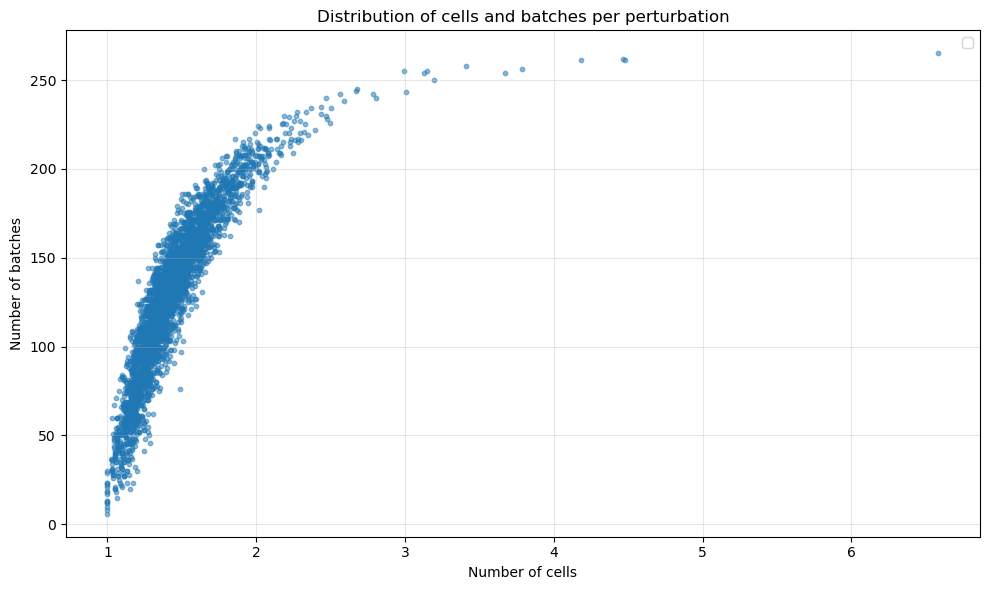

In [62]:
sum_n_cells = n_cells_perturb.groupby('gene')['n_cells'].mean()
n_batches = pbulk_adata.obs.value_counts('gene', ascending=True)
pl_df = pd.concat([n_batches, sum_n_cells], axis=1)
pl_df = pl_df.drop('non-targeting')
plt.figure(figsize=(10, 6))
plt.scatter(pl_df['n_cells'], pl_df['count'], alpha=0.5, s=10)
plt.xlabel('Number of cells')
plt.ylabel('Number of batches')
plt.title('Distribution of cells and batches per perturbation')
plt.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()


In [65]:
pbulk_adata = pbulk_adata[pbulk_adata.obs['n_cells'] > 2].copy()

/tmp/ipykernel_2955699/4003831512.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


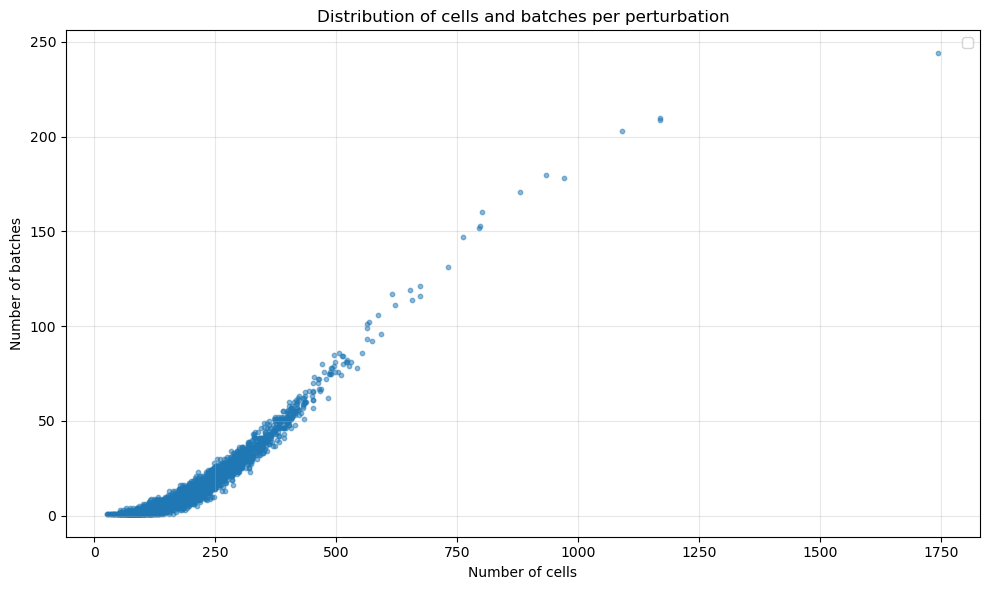

In [67]:
sum_n_cells = n_cells_perturb.groupby('gene')['n_cells'].sum()
n_batches = pbulk_adata.obs.value_counts('gene', ascending=True)
pl_df = pd.concat([n_batches, sum_n_cells], axis=1)
pl_df = pl_df.drop('non-targeting')
plt.figure(figsize=(10, 6))
plt.scatter(pl_df['n_cells'], pl_df['count'], alpha=0.5, s=10)
plt.xlabel('Number of cells')
plt.ylabel('Number of batches')
plt.title('Distribution of cells and batches per perturbation')
plt.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()


In [77]:
pbulk_adata.write_h5ad('/mnt/oak/users/emma/data/GWT/K562_gwps_filt_pseudobulk.for_DE.h5ad')

### Split perturbations into chunks

In [78]:
all_targets = pbulk_adata.obs['gene'].unique().tolist()
len(all_targets)

3082

In [79]:
chunk_size = 75
chunk_split_seed = 24387
all_targets = pbulk_adata.obs['gene'].unique().tolist()

# Randomize targets before splitting (without replacement)
np.random.seed(chunk_split_seed)
np.random.shuffle(all_targets)

# Split all_targets into groups based on chunk_size
target_chunks = [all_targets[i:i+chunk_size] for i in range(0, len(all_targets), chunk_size)]

# Initialize a binary matrix with zeros
target_chunk_matrix = pd.DataFrame(0, 
                                index=all_targets, 
                                columns=[f'chunk_{i}' for i in range(len(target_chunks))])

# Fill the matrix with 1s for each target in its respective chunk
for chunk_idx, chunk in enumerate(target_chunks):
    target_chunk_matrix.loc[chunk, f'chunk_{chunk_idx}'] = 1


target_chunk_matrix.to_csv('/mnt/oak/users/emma/data/GWT/K562_gwps_filt_pseudobulk.target2chunk.csv')

In [80]:
target_chunk_matrix.shape

(3082, 42)

## Run DESeq2 in chunks of perturbations

On comino:
```bash
for chunk in {0..67}; do sbatch --gres=gpu:1 --mem=30G --wrap="python k562_run_DE_chunk.py --chunk_ix ${chunk}"; done
```

## Merge DESeq2 results

In [3]:
sys.path.append('../')
from DE_analysis_utils import *

In [4]:
def parse_DE_results_2_adata(df):
    all_dfs = {}
    for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
        stat_df = df.pivot(values=stat, columns='variable', index='target_contrast')
        all_dfs[stat] = stat_df

    DE_anndata = anndata.AnnData(
        layers = all_dfs.copy()
    )

    DE_anndata.obs_names = all_dfs['log_fc'].index.tolist()
    DE_anndata.var_names = all_dfs['log_fc'].columns.tolist()
    DE_anndata.obs = df[['target_contrast', 'culture_condition']].drop_duplicates().set_index('target_contrast').loc[DE_anndata.obs_names]
    DE_anndata.obs['target_contrast'] = DE_anndata.obs_names.values
    DE_anndata.obs_names = DE_anndata.obs['target_contrast'] + '_' + DE_anndata.obs['culture_condition']
    return(DE_anndata)

In [5]:
import glob
import pandas as pd

# Get all chunk result files
de_results_files = glob.glob('/mnt/oak/users/emma/data/GWT/K562_DE_analysis/tmp/DE_results.chunk_*.csv.gz')

de_results_adatas = []

for file in tqdm(de_results_files, desc="Processing DE result files"):
    try:
        df = pd.read_csv(file, compression='gzip', index_col=0)
        df = df.rename({'contrast': 'target_contrast'}, axis=1)
        de_results_adatas.append(parse_DE_results_2_adata(df))
    except EOFError:
        continue

Processing DE result files: 100%|██████████| 42/42 [00:37<00:00,  1.13it/s]


In [7]:
combined_de_adata = anndata.concat(de_results_adatas, label='chunk')
combined_de_adata.obs_names = combined_de_adata.obs_names.str.split('-').str[0]
assert combined_de_adata.obs_names.is_unique
combined_de_adata.obs['target_contrast_gene_name'] = combined_de_adata.obs['target_contrast'].copy()

In [10]:
n_cells_perturb = n_cells_perturb.groupby('gene')['n_cells'].sum().reset_index()
# Add n cells per perturbation
obs_names = combined_de_adata.obs_names.copy()
obs_df = pd.merge(combined_de_adata.obs, n_cells_perturb.rename({'gene':'target_contrast', 'n_cells':'n_cells_target'}, axis=1))
obs_df.index = obs_names
combined_de_adata.obs = obs_df.copy()

In [11]:
datadir = '/mnt/oak/users/emma/data/GWT/K562_DE_analysis/'
combined_de_adata.write_h5ad(datadir + f'K562.merged_DE_results.h5ad')

Get stats

In [15]:
k562_stats = get_de_stats(combined_de_adata, signif_col = 'adj_p_value', effect_col = 'log_fc')
effect_in_k562_targets = k562_stats[k562_stats['n_total_de_genes'] > 0].target_name.tolist()
combined_de_adata.var['gene_name'] = combined_de_adata.var_names.values

In [16]:
len(effect_in_k562_targets)

2691

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'
# adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)

In [7]:
DE_stats[DE_stats['target_name'] == 'PPID']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
7876,ENSG00000171497,PPID,Rest,265.0,0,1,1,-11.144094,True,52.434420,False,1 DE gene,on-target KD
13939,ENSG00000171497,PPID,Stim8hr,218.0,0,1,1,-14.253945,True,95.587345,False,1 DE gene,on-target KD


Run MASH

In [18]:
import pymash

In [84]:
# Split effect_in_k562_targets into 50 bins of randomly sampled values
np.random.seed(42)  # For reproducibility
# Shuffle targets and ensure no overlap between bins by using array_split on the full shuffled array
shuffled_targets = np.random.permutation(effect_in_k562_targets)
binned_targets = np.array_split(shuffled_targets, 10)


In [86]:
# Train on first bin
train_targets = binned_targets[0]
# Fit model on all other bins
test_targets = binned_targets[1:]

In [87]:
# Train MASH model on first bin
K562_results_long = get_DE_results_long(combined_de_adata, targets=train_targets, effect_estimates =['log_fc', 'lfcSE'])
K562_results_long['test'] = K562_results_long['target_contrast'].astype(str) + '_' + K562_results_long['gene'].astype(str)
Tcells_results_long = get_DE_results_long(adata_de, targets=train_targets, effect_estimates =['log_fc', 'lfcSE'], gene_id_col='gene_name')
Tcells_results_long['test'] = Tcells_results_long['target_contrast_gene_name'].astype(str) + '_' + Tcells_results_long['gene_name'].astype(str)
Tcells_Bhat = Tcells_results_long.pivot(index='test', values='log_fc', columns='culture_condition')
Tcells_Shat = Tcells_results_long.pivot(index='test', values='lfcSE', columns='culture_condition')
Bhat = pd.concat([K562_results_long.set_index('test')['log_fc'], Tcells_Bhat], axis=1).dropna().T
Shat = pd.concat([K562_results_long.set_index('test')['lfcSE'], Tcells_Shat], axis=1).dropna().T

In [88]:
mash = pymash.tl.Mash(Bhat, Shat)
strong_tests = mash.get_strong_subset(thresh=0.01)
random_tests = mash.get_random_subset(n=20000)

Ulist_canonical = pymash.covariance_utils.cov_canonical(mash)
mash.extend_Ulist(Ulist_canonical, overwrite=False)

# Subset to strong tests
mash_strong = mash.copy()
mash_strong.adata = mash_strong.adata[:, random_tests].copy()

# Get PC based covariances
Ulist_pca = pymash.covariance_utils.cov_pca(mash_strong)
Ulist_ed = pymash.covariance_utils.cov_ed(mash_strong, Ulist_pca)
mash.extend_Ulist(Ulist_ed)

# Fit on subset of tests
mash.fit(subset_vars=random_tests, return_full=False)

# Get posterior for all tests
mash.predict()

all_res_df = mash.get_results()

 - Computing 20000 x 301 likelihood matrix.
 - Likelihood calculations took 1.21 seconds.
 - Fitting model with 301 mixture components.
 - Model fitting took 34.17 seconds.
 - Computing 1565817 x 301 likelihood matrix.
 - Likelihood calculations took 101.54 seconds.
 - Computing posterior matrices.
 - Computation allocated took 16.42 seconds.


In [89]:
# Fit mash on all other bins
from tqdm.notebook import tqdm
for ts in tqdm(test_targets, desc="Processing test targets"):
    K562_results_long = get_DE_results_long(combined_de_adata, targets=ts, effect_estimates =['log_fc', 'lfcSE'])
    K562_results_long['test'] = K562_results_long['target_contrast'].astype(str) + '_' + K562_results_long['gene'].astype(str)
    Tcells_results_long = get_DE_results_long(adata_de, targets=ts, effect_estimates =['log_fc', 'lfcSE'], gene_id_col='gene_name')
    Tcells_results_long['test'] = Tcells_results_long['target_contrast_gene_name'].astype(str) + '_' + Tcells_results_long['gene_name'].astype(str)
    Tcells_Bhat = Tcells_results_long.pivot(index='test', values='log_fc', columns='culture_condition')
    Tcells_Shat = Tcells_results_long.pivot(index='test', values='lfcSE', columns='culture_condition')
    Bhat = pd.concat([K562_results_long.set_index('test')['log_fc'], Tcells_Bhat], axis=1).dropna().T
    Shat = pd.concat([K562_results_long.set_index('test')['lfcSE'], Tcells_Shat], axis=1).dropna().T

    # Predict on test target from model on train targets
    mash_test = pymash.tl.Mash(Bhat, Shat)
    mash_test.extend_Ulist(mash.get_Ulist())
    mash_test.fitted_g = mash.fitted_g.copy()
    mash_test.predict()
    ts_res_df = mash.get_results()
    all_res_df = pd.concat([all_res_df, ts_res_df])

Processing test targets:   0%|          | 0/9 [00:00<?, ?it/s]

 - Computing 1559628 x 301 likelihood matrix.
 - Likelihood calculations took 102.31 seconds.
 - Computing posterior matrices.
 - Computation allocated took 16.30 seconds.
 - Computing 1572006 x 301 likelihood matrix.
 - Likelihood calculations took 101.29 seconds.
 - Computing posterior matrices.
 - Computation allocated took 16.85 seconds.
 - Computing 1590573 x 301 likelihood matrix.
 - Likelihood calculations took 102.68 seconds.
 - Computing posterior matrices.
 - Computation allocated took 17.09 seconds.
 - Computing 1565817 x 301 likelihood matrix.
 - Likelihood calculations took 101.75 seconds.
 - Computing posterior matrices.
 - Computation allocated took 16.31 seconds.
 - Computing 1596762 x 301 likelihood matrix.
 - Likelihood calculations took 103.77 seconds.
 - Computing posterior matrices.
 - Computation allocated took 17.47 seconds.
 - Computing 1572006 x 301 likelihood matrix.
 - Likelihood calculations took 101.50 seconds.
 - Computing posterior matrices.
 - Computatio

In [90]:
all_res_df.to_parquet('/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/MASH_comparison_results.parquet')

In [1]:
adata_de

NameError: name 'adata_de' is not defined

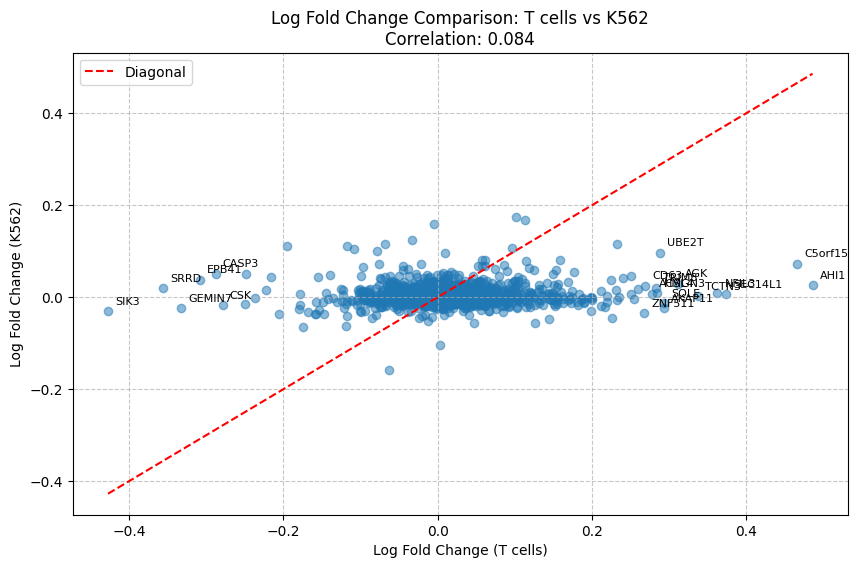

In [76]:
compare_g_df = res_df.pivot(index='test', columns='index', values='PosteriorMean')
# compare_g_df.columns = ['CD4T', 'log_fc_k562']
compare_g_df = compare_g_df.dropna()  # Store the result back in compare_g_df

# Calculate correlation coefficient
corr = compare_g_df['CD4T'].corr(compare_g_df['K562'])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(compare_g_df['CD4T'], compare_g_df['K562'], alpha=0.5)
plt.xlabel('Log Fold Change (T cells)')
plt.ylabel('Log Fold Change (K562)')
plt.title(f'Log Fold Change Comparison: T cells vs K562\nCorrelation: {corr:.3f}')
plt.grid(True, linestyle='--', alpha=0.7)

# Add diagonal line
min_val = min(compare_g_df['CD4T'].min(), compare_g_df['K562'].min())
max_val = max(compare_g_df['CD4T'].max(), compare_g_df['K562'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Diagonal')

# Find top genes (those with largest absolute fold changes in either direction)
compare_g_df['max_abs_fc'] = compare_g_df[['CD4T', 'K562']].abs().max(axis=1)
top_genes = compare_g_df.nlargest(20, 'max_abs_fc')

# Annotate top genes
for gene in top_genes.index:
    plt.annotate(gene, 
                (top_genes.loc[gene, 'CD4T'], 
                 top_genes.loc[gene, 'K562']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.legend()
plt.show()

,log_fc_tcells,log_fc_k562
gene_name,,
DPM1,-0.331023,-0.350677
C1orf112,-0.169940,-0.010827
FUCA2,0.021588,1.131006
GCLC,-0.490303,1.049060
NIPAL3,-0.259764,1.520100
...,...,...
DHRS11,-1.305003,-0.086635
ACACA,-0.571932,-1.084140
MRM1,-0.258856,1.044530
